In [48]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tqdm.autonotebook import tqdm as notebook_tqdm
# importing the data
from data import *
X = X.T
Y = Y.T
x_train = np.array([*X[:40],*Y[:40]])
x_test = np.array([*X[40:],*Y[40:]])
y_train = np.ones(80)
y_train[40:] = -np.ones(40)
y_test = np.ones(20)
y_test[10:] = -np.ones(10)


TSNE

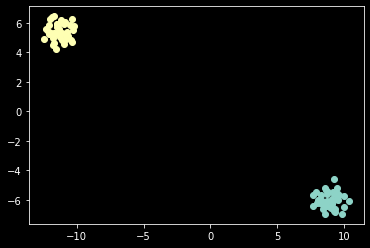

In [51]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=30, n_iter = 1000).fit_transform(x_train)

plt.scatter(X_embedded[:40,0],X_embedded[:40,1], label='X')
plt.scatter(X_embedded[40:,0],X_embedded[40:,1], label='Y')
plt.show()

SVM

In [131]:
from sklearn import svm

accuracy = lambda predicted, label: np.mean(predicted==label)

clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy(y_pred, y_test)

1.0

In [132]:
print(f"Slab thickness {2/np.linalg.norm(clf.coef_)}")

Slab thickness 117.73902605644058


Now, our own svm trained using subgradient method

In [115]:
accuracy = lambda predicted, label: torch.mean((predicted==label).float())

import torch
class svm:
    @classmethod
    def __init__(self, trade_off: int = 100):
        self.w = None
        self.b = None
        self.trade_off = torch.tensor(trade_off)
        self.learning_rate = None
        self.best_w = None
        self.best_b = None
        self.best_loss = torch.tensor(1e9)
        

    @staticmethod
    def shuffle(train: torch.tensor, labels: torch.tensor):
        """
        Shuffles the data in a random permutation
        """
        n = train.shape[0]
        permutation = torch.randperm(n)
        train = train[permutation]
        labels = labels[permutation]
        return train, labels
    
    @staticmethod
    def iterate_minibatches(train : torch.tensor, labels: torch.tensor, batch_size : int):
        """
        Gives minibatches
        """
        for start_idx in range(0, train.shape[0] + 1 - batch_size, batch_size):
            excerpt = slice(start_idx, start_idx+batch_size)
            yield train[excerpt], labels[excerpt]

    @classmethod
    def cost(self, train, labels):
        return self.w @ self.w + torch.mean(torch.maximum( torch.zeros(train.shape[0]) , torch.ones(train.shape[0]) - labels @ (train @ self.w + self.b)))

    
    @classmethod
    def fit_util(self, train: torch.tensor, labels: torch.tensor):
        """
        Utility function for fit
        """
        batch_size = train.shape[0]
        indices = (labels * (train @ self.w + self.b )) < 1.
        grad_b = -torch.sum(labels[indices])
        grad_w = 2 * self.w  - self.trade_off * (labels[indices] @ train[indices]) / batch_size
        self.b -=  self.learning_rate * grad_b
        self.w -= self.learning_rate * grad_w
        if self.best_loss > self.cost(train, labels):
            self.best_b = self.b
            self.best_w = self.w
            self.best_loss = self.cost(train, labels)
        

    @classmethod
    def fit(self, train, labels, learning_rate : int = 0.1 ,epochs : int = 10, batch_size = 10):
        """
        Trains the weights
        """
        self.learning_rate = torch.tensor(learning_rate)
        s = train.shape[1]
        self.w = torch.normal(torch.zeros(s)).to(torch.float64)
        self.b = torch.tensor(0.).to(torch.float64)
        

        for epoch in range(epochs):
            self.learning_rate = 1/(epoch+1)
            train, labels = self.shuffle(train, labels)
            for x,y in self.iterate_minibatches(train, labels, batch_size):
                self.fit_util(x, y)
        self.b = self.best_b
        self.w = self.best_w

    @classmethod
    def predict(self, test):
        """
        returns the predicted label
        """
        logits = test @ self.w + self.b
        return torch.sign(logits)
    
    @classmethod
    def accuracy(self, test : torch.tensor, ground_truth: torch.tensor):
        """
        Returns the accuracy of the model given
        test datapoints, and ground truth for those
        datapoints
        """
        predicted = self.predict(test)
        return torch.mean((predicted == ground_truth).float())




In [128]:

x_train_ = torch.tensor(x_train)
x_test_ = torch.tensor(x_test)
y_train_ = torch.tensor(y_train)
y_test_ = torch.tensor(y_test)

clf = svm(0.01)
clf.fit(x_train_, y_train_, epochs = 500, batch_size = 4, learning_rate = 0.01)
y_pred = clf.predict(x_test_)
print("The accuracy of our model is {}".format(clf.accuracy(x_test_, y_test_)))

tensor([ 1.3585,  1.1028,  1.0389,  1.1752,  1.0235,  1.1217,  1.3530,  1.3250,
         1.1858,  1.2415,  1.2413,  1.1959,  1.1574,  1.0210,  1.1830,  1.1437,
         1.2016,  1.2565,  1.0542,  1.2417,  1.1424,  1.0186,  1.1939,  1.1415,
         1.0985,  1.1338,  1.1386,  1.0051,  1.0064,  1.3481,  1.1792,  1.0099,
         1.1334,  1.0911,  1.2716,  1.0127,  1.0353,  1.0781,  1.0799,  1.1447,
        -1.1008, -1.1575, -1.1918, -1.0187, -1.0026, -1.0442, -1.0885, -1.0391,
        -1.1627, -1.1171, -0.9924, -1.0931, -1.0050, -1.0258, -1.1960, -1.2713,
        -1.0220, -1.1494, -1.0048, -1.2286, -1.0629, -1.1604, -1.2143, -1.0536,
        -1.2235, -1.0812, -1.2859, -1.0093, -1.1750, -1.0151, -1.1741, -1.1890,
        -1.0922, -1.1615, -1.1111, -1.1099, -1.1037, -0.9969, -1.0413, -1.0591],
       dtype=torch.float64)
The accuracy of our model is 1.0


In [129]:
torch.sqrt(4/(clf.w@clf.w))

tensor(117.1442, dtype=torch.float64)